In [95]:
# generate data
import Distributions
using Revise
using ForneyLab
using Random
import ProgressMeter
using Plots

Random.seed!(42)

n_samples = 100

dimensionality = 2
rθ = [-1.9, 2.9]
ms = [[0.8, 0.2], [0.2, 0.8]]
σ(w, x) = 1/(1+exp(-w'x))

A_data = [0.9 0.1; 0.1 0.9] # Transition probabilities (some transitions are impossible)

s_0_data = [1.0, 0.0] # Initial state

# Generate some data
s_data = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
s_t_min_data = s_0_data
for t in 1:n_samples
    a = A_data*s_t_min_data
    s_data[t] = sample(ProbabilityDistribution(Categorical, p=a./sum(a))) # Simulate state transition
    
    s_t_min_data = s_data[t]
end
sampled_means = [ms[argmax(s_data[i])] for i in 1:n_samples]
πs = map(x -> σ(rθ, x), sampled_means)
outputs = [rand(Distributions.Bernoulli(πs[i])) for i in 1:n_samples]

100-element Vector{Bool}:
 1
 1
 1
 0
 1
 1
 1
 1
 1
 1
 1
 0
 1
 ⋮
 1
 1
 1
 1
 0
 1
 1
 1
 1
 1
 1
 0

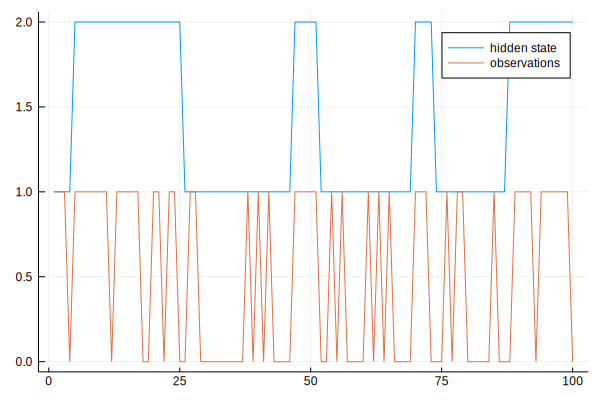

In [99]:
plot(argmax.(s_data), label="hidden state")
plot!(outputs, label="observations")

### Learning + Planning

In [100]:
# test nonlinear

using LinearAlgebra
import ForneyLab: unsafeMean, unsafeCov

graph = FactorGraph()

T = n_samples
x = Vector{Variable}(undef, T)
z = Vector{Variable}(undef, T)
s = Vector{Variable}(undef, T) # one-hot coding
y = Vector{Variable}(undef, T)

@RV A ~ Dirichlet([0.5 0.5; 0.5 0.5])
@RV s_0 ~ Categorical(1/dimensionality*ones(dimensionality))

@RV m_1 ~ GaussianMeanPrecision([0.9, 0.1], 1e-4*Matrix(Diagonal(ones(dimensionality))))
@RV w_1 ~ Wishart(1e-4*Matrix(Diagonal(ones(dimensionality))), dimensionality)
@RV m_2 ~ GaussianMeanPrecision([0.2, 0.8], 1e-4*Matrix(Diagonal(ones(dimensionality))))
@RV w_2 ~ Wishart(1e-4*Matrix(Diagonal(ones(dimensionality))), dimensionality)

@RV θ  ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(dimensionality,)), placeholder(:W_θ, dims=(dimensionality, dimensionality)))
f(w, x) = 1/(1+exp(-w'x))
s_t_min = s_0
for i in 1:T
    @RV s[i] ~ Transition(s_t_min, A)
    @RV z[i] ~ GaussianMixture(s[i], m_1, w_1, m_2, w_2)
    @RV x[i] ~ Nonlinear{Sampling}(θ, z[i], g=f, in_variates=[Multivariate, Multivariate], out_variate=Univariate)
    @RV y[i] ~ Bernoulli(x[i])
    
    s_t_min = s[i]
    placeholder(y[i], :y, index=i)
end

In [101]:
draw();

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.47.2 (20210527.0053)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8461349709310475644 -->
 
 8461349709310475644 
 
 = 
 equ_w_1_63 
 
<!-- 14195297469242494390 -->
 
 14195297469242494390 
 
 GM 
 gaussianmixture_63 
 
<!-- 8461349709310475644--14195297469242494390 -->
 
 8461349709310475644--14195297469242494390 
 
 w_1 
 4 w1 
 1 1 
 
<!-- 3945342374589556640 -->
 
 3945342374589556640 
 
 = 
 equ_w_1_62 
 
<!-- 8461349709310475644--3945342374589556640 -->
 
 8461349709310475644--3945342374589556640 
 
 w_1 
 3 3 
 2 2 
 
<!-- 2529593940542754890 -->
 
 2529593940542754890 
 
 GM 
 gaussianmixture_42 
 
<!-- 14598747247443581909 -->
 
 14598747247443581909 
 
 = 
 equ_A_91 
 
<!-- 4205743422207333835 -->
 
 4205743422207333835 
 
 = 
 equ_A_90 
 
<!-- 14598747247443581909--4205743422207333835 -->
 
 14598747247443581909--4205743422207333835 
 
 A 
 3 3 
 2 2 
 
<!-- 6782167235522535912 -->
 
 6782167235522535912 
 
 T 
 transition_91 
 
<!-- 14598747247443581909--6782167235522535912 -->
 
 14598747247443581909--6782167235522535912 
 
 A 
 3 a 
 1 1 
 
<!-- 16402832691736901307 -->
 
 16402832691736901307 
 
 = 
 equ_θ_2 
 
<!-- 6790623923078295056 -->
 
 6790623923078295056 
 
 = 
 equ_θ_1 
 
<!-- 16402832691736901307--6790623923078295056 -->
 
 16402832691736901307--6790623923078295056 
 
 θ 
 3 3 
 2 2 
 
<!-- 12313903745349629615 -->
 
 12313903745349629615 
 
 g{Sampling} 
 nonlinear_2 
 
<!-- 16402832691736901307--12313903745349629615 -->
 
 16402832691736901307--12313903745349629615 
 
 θ 
 2 in1 
 1 1 
 
<!-- 700775559858710393 -->
 
 700775559858710393 
 
 = 
 equ_w_1_61 
 
<!-- 3584976104830885011 -->
 
 3584976104830885011 
 
 = 
 equ_w_1_60 
 
<!-- 700775559858710393--3584976104830885011 -->
 
 700775559858710393--3584976104830885011 
 
 w_1 
 3 3 
 2 2 
 
<!-- 17285696561660750269 -->
 
 17285696561660750269 
 
 GM 
 gaussianmixture_61 
 
<!-- 700775559858710393--17285696561660750269 -->
 
 700775559858710393--17285696561660750269 
 
 w_1 
 4 w1 
 1 1 
 
<!-- 4564765569072143538 -->
 
 4564765569072143538 
 
 = 
 equ_s_70_1 
 
<!-- 7970110307747961524 -->
 
 7970110307747961524 
 
 T 
 transition_71 
 
<!-- 4564765569072143538--7970110307747961524 -->
 
 4564765569072143538--7970110307747961524 
 
 s_70 
 2 in1 
 3 3 
 
<!-- 16908081267286970813 -->
 
 16908081267286970813 
 
 T 
 transition_70 
 
<!-- 4564765569072143538--16908081267286970813 -->
 
 4564765569072143538--16908081267286970813 
 
 s_70 
 1 out 
 1 1 
 
<!-- 9615384923093978291 -->
 
 9615384923093978291 
 
 GM 
 gaussianmixture_70 
 
<!-- 4564765569072143538--9615384923093978291 -->
 
 4564765569072143538--9615384923093978291 
 
 s_70 
 2 z 
 2 2 
 
<!-- 4209573096382904790 -->
 
 4209573096382904790 
 
 = 
 equ_s_57_1 
 
<!-- 18212497191138394335 -->
 
 18212497191138394335 
 
 T 
 transition_58 
 
<!-- 4209573096382904790--18212497191138394335 -->
 
 4209573096382904790--18212497191138394335 
 
 s_57 
 2 in1 
 3 3 
 
<!-- 205083426116692348 -->
 
 205083426116692348 
 
 T 
 transition_57 
 
<!-- 4209573096382904790--205083426116692348 -->
 
 4209573096382904790--205083426116692348 
 
 s_57 
 1 out 
 1 1 
 
<!-- 2120102101108937969 -->
 
 2120102101108937969 
 
 GM 
 gaussianmixture_57 
 
<!-- 4209573096382904790--2120102101108937969 -->
 
 4209573096382904790--2120102101108937969 
 
 s_57 
 2 z 
 2 2 
 
<!-- 16161254769935455817 -->
 
 16161254769935455817 
 
 GM 
 gaussianmixture_16 
 
<!-- 542159061012975834 -->
 
 542159061012975834 
 
 = 
 equ_s_91_1 
 
<!-- 16062820188226329999 -->
 
 16062820188226329999 
 
 GM 
 gaussianmixture_91 
 
<!-- 542159061012975834--16062820188226329999 -->
 
 542159061012975834--16062820188226329999 
 
 s_91 
 2 z 
 2 2 
 
<!-- 3585265841163640454 -->
 
 3585265841163640454 
 
 T 
 transition_92 
 
<!-- 542159061012975834

In [26]:
vague(Wishart, 2)

W(v=diag[1.00e+12, 1.00e+12], nu=2.00)


In [27]:
# Define posterior factorization
pfz = PosteriorFactorization(A, [s_0; s], m_1, w_1, m_2, w_2, z, ids=[:A, :S, :M1, :W1, :M2, :W2, :Z]);

In [28]:
# Compile algorithm
algo = messagePassingAlgorithm(free_energy=true)

# Generate source code
src_code = algorithmSourceCode(algo, free_energy=true);

In [29]:
# println(src_code)

In [30]:
# Load algorithm
eval(Meta.parse(src_code))

freeEnergy (generic function with 1 method)

In [31]:
n_messages = length(initZ());

function initZ(n_messages)
    messages = Array{Message}(undef, n_messages)
    for i in 1:length(messages)
        messages[i] = Message(vague(GaussianMeanPrecision, 2))
    end
    messages
end

initZ (generic function with 2 methods)

In [32]:
messages = initZ(n_messages);

In [38]:
# Initial posterior factors
marginals = Dict{Symbol, ProbabilityDistribution}(:A => ProbabilityDistribution(MatrixVariate, Dirichlet, a=[0.9 0.1; 0.1 0.9]), 
                                                  :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[0.9, 0.1], w=Matrix(Diagonal(ones(2)))),
                                                  :w_1 => ProbabilityDistribution(MatrixVariate, Wishart, v=Matrix(Diagonal(ones(dimensionality))), nu=2.00),
                                                  :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[0.2, 0.8], w=Matrix(Diagonal(ones(2)))),
                                                  :w_2 => ProbabilityDistribution(MatrixVariate, Wishart, v=Matrix(Diagonal(ones(dimensionality))), nu=2.00))

for i in 0:n_samples
    marginals[:s_*i] = ProbabilityDistribution(Univariate, Categorical, p=[0.8, 0.1])
end

# Initialize data
data = Dict(:y => outputs, :m_θ => [-0.9, 0.5], :W_θ => Matrix(Diagonal(ones(dimensionality))))
n_its = 50

# Run algorithm
F = Vector{Float64}(undef, n_its)
ProgressMeter.@showprogress for i in 1:n_its
    stepZ!(data, marginals, messages)
    stepS!(data, marginals)
#     stepA!(data, marginals)
    stepM1!(data, marginals)
#     stepW1!(data, marginals)
    stepM2!(data, marginals)
#     stepW2!(data, marginals) 
    F[i] = freeEnergy(data, marginals)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [39]:
unsafeMean(marginals[:θ])

2-element Vector{Float64}:
 -1.6408135313343895
  0.910979291373981

In [40]:
veθ = unsafeCov(marginals[:θ])

2×2 Matrix{Float64}:
 0.571723   0.0300337
 0.0300337  1.44313

In [41]:
es = [unsafeMean(marginals[:s_*i]) for i in 1:n_samples]

10-element Vector{Vector{Float64}}:
 [0.999999999998, 1.9999999999980003e-12]
 [0.9999999999989999, 1.0000632239129554e-12]
 [0.9999999999989999, 1.0000632239119553e-12]
 [0.9999999999989999, 1.0000632239119553e-12]
 [0.9999999999989999, 1.0000632239119553e-12]
 [0.9999999999989999, 1.0000632239119553e-12]
 [0.9999999999989999, 1.0000632239119553e-12]
 [0.9999999999989999, 1.0000632239119553e-12]
 [0.9999999999989999, 1.0000632239119553e-12]
 [0.9999999999989999, 1.0000632239109553e-12]

In [42]:
ez = [unsafeMean(marginals[:z_*i]) for i in 1:n_samples]

10-element Vector{Vector{Float64}}:
 [1.0770402026830688, 0.03900493313293816]
 [0.46074797055037614, 0.381265606002995]
 [1.077040202683917, 0.03900493313254707]
 [1.077040202683917, 0.03900493313254709]
 [1.077040202683917, 0.03900493313254709]
 [1.077040202683917, 0.03900493313254707]
 [1.077040202683917, 0.03900493313254709]
 [1.077040202683917, 0.03900493313254707]
 [0.4607479705503761, 0.38126560600299486]
 [1.0770101198534243, 0.039091945947888174]

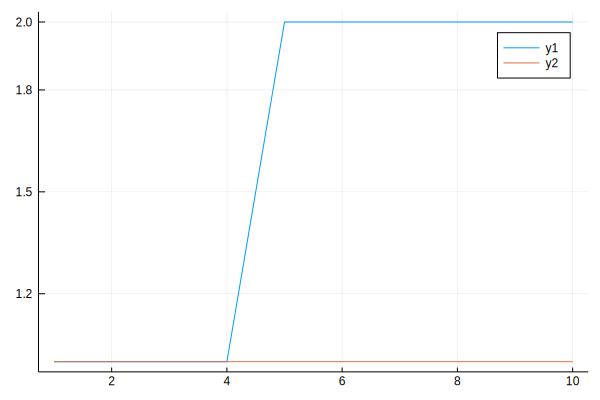

In [43]:
plot(map(x -> x[2], findmax.(s_data)))
plot!(map(x -> x[2], findmax.(es)))

### Learning

In [46]:
sampled_means = [ms[argmax(s_data[i])] for i in 1:n_samples]
πs = map(x -> σ(rθ, x), sampled_means)
outputs = [rand(Distributions.Bernoulli(πs[i])) for i in 1:n_samples];

In [102]:
# test nonlinear

using LinearAlgebra
import ForneyLab: unsafeMean, unsafeCov

graph = FactorGraph()

T = n_samples
z = Vector{Variable}(undef, T)
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

@RV θ  ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(dimensionality,)), placeholder(:W_θ, dims=(dimensionality, dimensionality)))
f(w, x) = 1/(1+exp(-w'x))
for i in 1:T
    @RV z[i] ~ GaussianMeanPrecision(sampled_means[i], huge*Matrix(Diagonal(ones(dimensionality))))
    @RV x[i] ~ Nonlinear{Sampling}(θ, z[i], g=f, in_variates=[Multivariate, Multivariate], out_variate=Univariate)
    @RV y[i] ~ Bernoulli(x[i])
    placeholder(y[i], :y, index=i)    
end

In [103]:
# Define posterior factorization
pfz = PosteriorFactorization();

# Compile algorithm
algo = messagePassingAlgorithm(free_energy=true)

# Generate source code
src_code = algorithmSourceCode(algo, free_energy=true);

In [104]:
# println(src_code)

In [105]:
# Load algorithm
eval(Meta.parse(src_code))

freeEnergy (generic function with 1 method)

In [106]:
n_messages = length(init());

function init(n_messages)
    messages = Array{Message}(undef, n_messages)
    for i in 1:length(messages)
        messages[i] = Message(vague(GaussianMeanPrecision, 2))
    end
    messages
end

init (generic function with 2 methods)

In [107]:
messages = init(n_messages)

# Initial posterior factors
marginals = Dict{Symbol, ProbabilityDistribution}()

# Initialize data
data = Dict(:y => outputs, :m_θ => [0.1, 0.2], :W_θ => Matrix(Diagonal(ones(dimensionality))))
n_its = 1000

# Run algorithm
F = Vector{Float64}(undef, n_its)
ProgressMeter.@showprogress for i in 1:100
    step!(data, marginals, messages)
    F[i] = freeEnergy(data, marginals)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


In [108]:
unsafeMean(marginals[:θ])

2-element Vector{Float64}:
 -1.2399736770316525
  1.5975322305031823

In [131]:
π̂ = [f(unsafeMean(marginals[:θ]), x) for x in sampled_means]
ô = [rand(Distributions.Bernoulli(π̂[i])) for i in 1:n_samples]

100-element Vector{Bool}:
 0
 0
 1
 1
 1
 0
 1
 1
 0
 1
 1
 0
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [132]:
sum((πs .- π̂).^2)/length(π̂)

0.009976169888403217

In [133]:
sum(abs.(ô .- outputs))

32

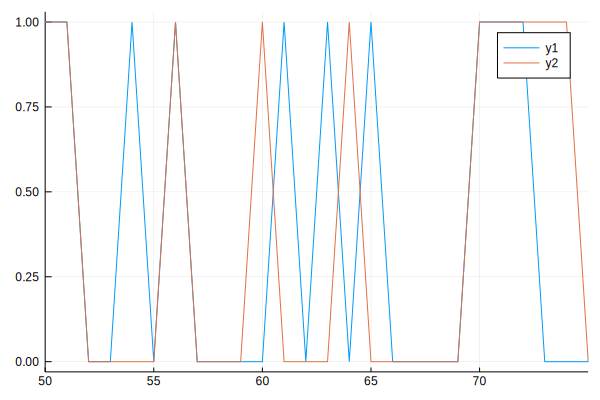

In [137]:
plot(outputs)
plot!(ô)
xlims!(50, 75)

### Planning

In [271]:
# test nonlinear

using LinearAlgebra
import ForneyLab: unsafeMean, unsafeCov

graph = FactorGraph()

T = n_samples
x = Vector{Variable}(undef, T)
z = Vector{Variable}(undef, T)
s = Vector{Variable}(undef, T) # one-hot coding
y = Vector{Variable}(undef, T)

@RV A ~ Dirichlet([0.9 0.1; 0.1 0.9])
@RV s_0 ~ Categorical(1/dimensionality*ones(dimensionality))

@RV m_1 ~ GaussianMeanPrecision([0.9, 0.1], 1e4*Matrix(Diagonal(ones(dimensionality))))
@RV w_1 ~ Wishart(1e-4*Matrix(Diagonal(ones(dimensionality))), dimensionality)
@RV m_2 ~ GaussianMeanPrecision([0.2, 0.8], 1e4*Matrix(Diagonal(ones(dimensionality))))
@RV w_2 ~ Wishart(1e-4*Matrix(Diagonal(ones(dimensionality))), dimensionality)

f(x) = 1/(1+exp(-rθ'x))
s_t_min = s_0
for i in 1:T
    @RV s[i] ~ Transition(s_t_min, A)
    @RV z[i] ~ GaussianMixture(s[i], m_1, w_1, m_2, w_2)
    @RV x[i] ~ Nonlinear{Sampling}(z[i], g=f, in_variates=[Multivariate], out_variate=Univariate)
    @RV y[i] ~ Bernoulli(x[i])
    
    s_t_min = s[i]
    placeholder(y[i], :y, index=i)
end

In [272]:
# Define posterior factorization
pfz = PosteriorFactorization(A, [s_0; s], m_1, w_1, m_2, w_2, z, ids=[:A, :S, :M1, :W1, :M2, :W2, :Z]);

In [273]:
# Compile algorithm
algo = messagePassingAlgorithm(free_energy=true)

# Generate source code
src_code = algorithmSourceCode(algo, free_energy=true);

In [274]:
# Load algorithm
eval(Meta.parse(src_code))

freeEnergy (generic function with 1 method)

In [288]:
# Initial posterior factors
marginals = Dict{Symbol, ProbabilityDistribution}(:A => ProbabilityDistribution(MatrixVariate, Dirichlet, a=[0.9 0.1; 0.1 0.9]), 
                                                  :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[0.9, 0.1], w=Matrix(Diagonal(ones(2)))),
                                                  :w_1 => ProbabilityDistribution(MatrixVariate, Wishart, v=Matrix(Diagonal(ones(dimensionality))), nu=2.00),
                                                  :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[0.2, 0.8], w=Matrix(Diagonal(ones(2)))),
                                                  :w_2 => ProbabilityDistribution(MatrixVariate, Wishart, v=Matrix(Diagonal(ones(dimensionality))), nu=2.00))

for i in 0:n_samples
    marginals[:s_*i] = ProbabilityDistribution(Univariate, Categorical, p=[0.6, 0.4])
end

# Initialize data
data = Dict(:y => outputs, :m_θ => [-0.9, 0.5], :W_θ => Matrix(Diagonal(ones(dimensionality))))
n_its = 50

# Run algorithm
F = Vector{Float64}(undef, n_its)
ProgressMeter.@showprogress for i in 1:n_its
    stepZ!(data, marginals, messages)
    stepS!(data, marginals)
#     stepA!(data, marginals)
    stepM1!(data, marginals)
#     stepW1!(data, marginals)
    stepM2!(data, marginals)
#     stepW2!(data, marginals) 
    F[i] = freeEnergy(data, marginals)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [289]:
ms = [unsafeMean(marginals[:s_*i]) for i in 0:n_samples]
st = argmax.(ms)

101-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

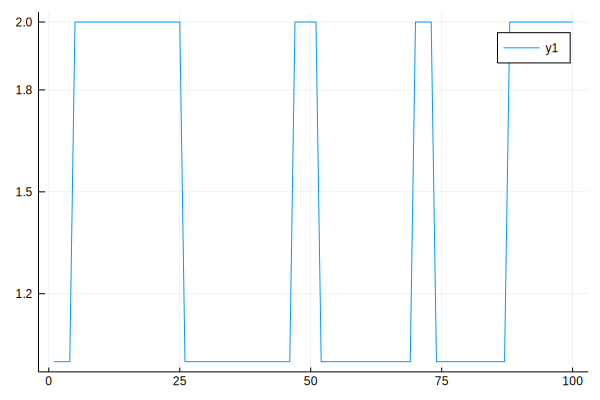

In [293]:
plot(argmax.(s_data))